# Elife Binary Random Forest Results

Andrew E. Davidson  
aedaivds@ucsc.edu 31/31/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0


In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

# import joblib
import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_1414649/402461529.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../de

In [3]:
# import local 
from analysis.utilities import findFile
from intraExtraRNA.elifeUtilities import loadElifeTrainingData
# from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# from models.randomForestHyperparmeterSearch import evaluateModel
# # from models.randomForestHyperparmeterSearch import tunningFramework
from models.plotROC import plotROC
from pipeline.dataFactory.utilities import urlify

In [4]:
def plotROCWrapper(XNP :np.array, 
                yNP :np.array, 
                model,
                title:str ) -> tuple[plt.figure, plt.axes, dict[int, float]]:
    '''
    arguments:
        XNP :
            samples to create prediction for
        y : 
            ground truth labels
    
        model:
            trained model 

    returns 
        fig:

        panel :
        
        dictionary :
            key = yProbability column idx
            value = area under ROC curve
 
    '''
    predictions  = model.predict(XNP)
    yProbability = model.predict_proba(XNP)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) #sharey=True
    
    #yProbability = yProbability[:,1]
    print(f'yNP.shape : {yNP.shape}')
    print(f'yProbability.shape : {yProbability.shape}' )
    
    classesToPlot = [1]
    aucDict = plotROC(
            axs, 
            yNP,
            yProbability,
            title,
            classesToPlot
    ) 

    return (fig, axs, aucDict)

In [5]:
def driver(
    hyperParameterSearchResultsPath : str,    
    pipelineStageName : str="best10CuratedDegree1_ce467ff",
    features : list[str] = ["Esophagus_Mucosa"],
    selectElifeCategories : list[str] = ["Healthy donor", "Esophagus Cancer"],
    ):
    '''
    TOOD

    arguments:
        hyperParameterSearchResultsPath:
            example
            d=/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/
            ${d}/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv
    '''

    retDict = dict()

    #
    # load training data
    #
    HUGO_Genes, elifeLungGenes, countDF, metaDF, XNP, yNP = loadElifeTrainingData(pipelineStageName,
                                                                                     features,
                                                                                     selectElifeCategories,
                                                                                     )
    retDict['HUGO_Genes'] = HUGO_Genes
    retDict['elifeLungGenes'] = elifeLungGenes
    retDict['countDF'] = countDF
    retDict['metaDF'] = metaDF
    retDict['XNP'] = XNP
    retDict['yNP'] = yNP
    
    print(f'HUGO_Genes\n{HUGO_Genes}\n')
    print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape}')
    display( metaDF.groupby("diagnosis").count().loc[ ["Healthy donor", "Esophagus Cancer"], :] )

    #
    # get best hyperparameter search results
    #
    print(f'\nhyperParameterSearchResultsPath:\n {hyperParameterSearchResultsPath}')
    rfhpDF = pd.read_csv(hyperParameterSearchResultsPath)

    bestParmetersDF = rfhpDF.sort_values(by='auc_mean', ascending=False).head(n=1)

    print(f'\n best hyperparameter search results')
    display( bestParmetersDF )
    retDict['bestHyperparameterSearchResults'] = bestParmetersDF
    
    parameterCols = ["max_features", "max_samples", "n_estimators", "max_depth"]
    kwags = bestParmetersDF.loc[:, parameterCols].head(n=1).to_dict(orient="records")[0]
    #
    # max_depth, max_features, and n_estimators must be integers
    # pandas to_csv() will change int columns to float if one of the values is missing
    # pandas uses Nan which is considered a float so the values in teh column get prompted
    # to float
    #

    for key in ["max_depth", "max_features", "n_estimators"] :
        parameter = kwags[ key ]
        if type(parameter) == float:
            # one of the values in this column was python None
            if math.isnan(parameter) :
                kwags[ key ] = None
            else :
                 kwags[ key ] = int(parameter)
        
    display(kwags)
    retDict['parameters'] = kwags



    #
    # train model
    #
    rfModel = RandomForestClassifier(**kwags)
    rfModel.fit(XNP, yNP)
    
    print("")
    display( rfModel )
    retDict['model'] = rfModel


    return retDict


2024-04-10 14:13:48,756 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:177] [len(elifeLungGenes) : 10]
2024-04-10 14:13:48,758 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [missingElifeGenes
 : ['ENSG00000180667.10', 'ENSG00000082269.16', 'ENSG00000148429.14']]


HUGO_Genes
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']

XNP.shape : (74, 7) yNP.shape : (74,)


,sample_id
diagnosis,
Healthy donor,43
Esophagus Cancer,31



hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.687619,0.063575,0.788889,0.094363,0.547619,0.124175,0.668254,0.068257,5,0.2,50,5.0


{'max_features': 5, 'max_samples': 0.2, 'n_estimators': 50, 'max_depth': 5}

RandomForestClassifier(max_depth=5, max_features=5, max_samples=0.2,
                       n_estimators=50)

yNP.shape : (74,)
yProbability.shape : (74, 2)
CPU times: user 22.8 s, sys: 3.01 s, total: 25.8 s
Wall time: 25.8 s


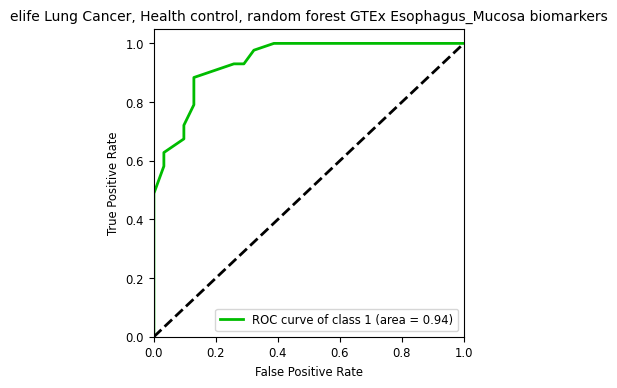

In [6]:
%%time
modelOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out"
outFile = "randomForestHyperparmeterSearch.csv"
hyperParameterSearchResultsPath = modelOut + "/" + outFile

dataDict = driver(hyperParameterSearchResultsPath)

XNP = dataDict['XNP']
yNP = dataDict['yNP']
randomForestModel = dataDict['model']
title = "elife Lung Cancer, Health control, random forest GTEx Esophagus_Mucosa biomarkers"
fig, panel, aucDict = plotROCWrapper(XNP, yNP, randomForestModel, title)

In [7]:
yNP

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
metaDF = dataDict['metaDF']
metaDF['diagnosis'].unique()


array(['Esophagus Cancer', 'Lung Cancer', 'Liver Cancer',
       'Stomach Cancer', 'Colorectal Cancer', 'Healthy donor'],
      dtype=object)